# Notebook: PyOlimp — Пример предкомпенсации

В этом ноутбуке представлен пример работы с системой **PyOlimp**,  
предназначенной для задачи **предкомпенсации искажений зрения** (рефракционных).

Используется **собственный модульный pipeline**, поддерживающий:
- загрузку и аугментацию специализированных датасетов (например, SCA-2023);
- обучение нейросетевых моделей.

🧠 Включён пример обучения и использования модели:
- `PrecompensationUSRNet` — модифицированная версия сети USRNet с поддержкой двойного ввода (изображение + PSF), предназначенная для задачи предкомпенсации.

Все модули и потоки обучения полностью реализованы в рамках библиотеки `pyolimp`.

### 📦 Импорт библиотек

В этом разделе осуществляется импорт всех необходимых модулей и компонентов, обеспечивающих загрузку данных, использование метрик качества, моделей предкомпенсации и утилит обработки изображений:

- `sys` — используется для добавления корневой директории проекта в системный путь, чтобы обеспечить доступ к внутренним модулям;
- `olimp.dataset.sca_2023`:
  - `sca_2023` — функция или объект для загрузки датасета SCA-2023;
  - `read_img_path` — функция для чтения путей к изображениям;
- `olimp.evaluation.loss.piq.MultiScaleSSIMLoss` — реализация метрики MS-SSIM из библиотеки PIQ, предназначенная для оценки структурного сходства на нескольких масштабах;
- `olimp.precompensation.nn.models.usrnet.PrecompensationUSRNet` — модифицированная версия нейросети USRNet, адаптированная для задач предкомпенсации;
- `olimp.processing.fft_conv` — функция для эффективной свёртки в частотной области (FFT);

Дополнительные библиотеки PyTorch и утилиты:
- `torch`, `torch.nn`, `torch.optim` — для создания, обучения и оптимизации нейросетей;
- `torch.utils.data.Dataset`, `DataLoader` — абстракции для работы с датасетами и мини-батчами;
- `torchvision.transforms`, `utils` — трансформации изображений и визуализация;
- `torch.nn.functional` — функциональные интерфейсы PyTorch (например, активации, потери и т.д.);

Вспомогательные библиотеки:
- `numpy` — для численных вычислений и работы с массивами;
- `matplotlib.pyplot` — для отображения изображений и построения графиков;
- `itertools.product` — для создания декартовых произведений (перебора параметров);
- `tqdm` — для отображения прогресс-баров при итерациях (например, в цикле обучения).

In [3]:
import sys
sys.path.append("../../../")

In [4]:
# dataset
from olimp.dataset.sca_2023 import sca_2023, read_img_path
# loss
from olimp.evaluation.loss.piq import MultiScaleSSIMLoss
# models
from olimp.precompensation.nn.models.usrnet import PrecompensationUSRNet
# utils
from olimp.processing import fft_conv

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch.nn.functional as F

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
from tqdm import tqdm

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# Чтение данных

## 🧾 Класс `PreCompensationDataset`

Кастомный датасет `PreCompensationDataset` предназначен для генерации пар (PSF, изображение) на основе выбранных категорий из датасета **SCA-2023**.

Особенности:
- Поддерживает загрузку изображений и PSF из разных подмножеств с помощью параметров `image_categories` и `psf_categories`;
- Для каждой категории загружаются пути к файлам с помощью функции `sca_2023`;
- Формируется **декартово произведение**: каждая PSF применяется ко всем изображениям;
- Возвращаемые изображения нормализуются (деление на 255), а PSF нормализуется и центрируется с помощью `torch.fft.fftshift`.

Выход `__getitem__`:
- `psf` — нормализованная и центрированная функция рассеивания точки;
- `image` — изображение с плавающей запятой в диапазоне [0, 1].

Этот датасет удобно использовать для обучения моделей предкомпенсации, позволяя комбинировать разные типы искажений.

In [8]:
class PreCompensationDataset(Dataset):
    
    def __init__(self, image_categories: dict, psf_categories: dict):
        # Получаем пути из всех категорий
        image_dict = sca_2023(categories=image_categories)
        psf_dict = sca_2023(categories=psf_categories)

        self.images = []
        for key in image_dict:
            self.images.extend(image_dict[key])

        self.psfs = []
        for key in psf_dict:
            self.psfs.extend(psf_dict[key])

        # Декартово произведение: все изображения со всеми PSF
        self.pairs = list(product(self.images, self.psfs))
    
    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        img_path, psf_path = self.pairs[idx]

        # Загрузка изображения
        image = read_img_path(img_path) / 255.0
            
        # Загрузка и нормализация PSF
        psf = read_img_path(psf_path).float()
        psf /= psf.sum()
        psf = torch.fft.fftshift(psf)

        return psf, image


In [9]:
dataset = PreCompensationDataset(
    image_categories={"Images/Real_images",},
    psf_categories={"PSFs/Broad"}
)

Output()

Output()

### 🧪 Разделение датасета на обучающую, валидационную и тестовую выборки

Для обучения и оценки модели датасет делится на три части:

- **Обучающая выборка** (`train_size`) — 40% от общего числа примеров;
- **Валидационная выборка** (`val_size`) — 40% от общего числа примеров;
- **Тестовая выборка** (`test_size`) — оставшиеся 20% (вычисляются как разность между полной длиной и суммой первых двух частей).

In [10]:
train_size = int(0.4 * len(dataset))
val_size   = int(0.4 * len(dataset))
test_size  = len(dataset) - (train_size + val_size)

print(train_size, val_size, test_size)

41574 41574 20788


### 🔀 Случайное разбиение датасета

In [11]:
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

### 📦 Загрузка данных (`DataLoader`)

Создаются загрузчики данных для обучения и валидации с использованием `torch.utils.data.DataLoader`:

- `train_dataloader` — загружает обучающую выборку:
  - `shuffle=True` — перемешивает данные перед каждой эпохой;
  - `batch_size=1` — используется размер батча 1 (можно изменить);
  - `pin_memory=True` — ускоряет передачу данных на GPU;
  - `num_workers=4` — число параллельных потоков загрузки;
  - `prefetch_factor=2` — количество предварительно загружаемых батчей на поток.

- `val_dataloader` — загружает валидационную выборку:
  - `shuffle=False` — порядок данных сохраняется;
  - остальные параметры аналогичны `train_dataloader`.

In [12]:
batchsize = 1

In [13]:
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=batchsize, pin_memory=True, num_workers=4, prefetch_factor=2)

In [14]:
val_dataloader = DataLoader(val_dataset, shuffle=False, batch_size=batchsize, pin_memory=True, num_workers=4, prefetch_factor=2)

In [15]:
val_dataloader = train_dataloader

### 🖼️ Визуализация изображений (`plot_images`)

Функция `plot_images` предназначена для удобной визуализации одного или нескольких изображений в виде сетки.

Особенности:
- Поддерживает как `torch.Tensor`, так и `numpy.ndarray`;
- Автоматически преобразует изображения к формату `float32` и диапазону [0, 1];
- Удаляет лишние размерности (`squeeze`) и преобразует формат из `CHW` в `HWC` при необходимости;
- Отображает изображения с помощью `matplotlib.pyplot.imshow`:
  - в оттенках серого, если изображение 2D;
  - в цвете, если изображение 3D;
- При передаче аргумента `titles` отображает заголовки с минимума и максимума значений изображения;
- Удаляет оси (`axis('off')`) для чистоты визуализации;
- Автоматически применяет `tight_layout()` и вызывает `plt.show()`.

In [16]:
def plot_images(images, titles=None, rows=1, figsize=(12, 3)):
    cols = len(images)
    fig, axs = plt.subplots(rows, cols, figsize=figsize)
    axs = np.atleast_1d(axs).ravel()

    for i, img in enumerate(images):
        # Приводим к numpy и float32
        if isinstance(img, torch.Tensor):
            arr = img.detach().cpu().to(torch.float32).numpy()
        elif isinstance(img, np.ndarray):
            arr = img.astype(np.float32)
        else:
            arr = np.array(img, dtype=np.float32)

        # Удаляем лишние каналы, если есть
        arr = arr.squeeze()
        if arr.ndim == 3 and arr.shape[0] in (1, 3):  # CHW -> HWC
            arr = arr.transpose(1, 2, 0)
        
        axs[i].imshow(arr, cmap='gray' if arr.ndim == 2 else None, vmin=0, vmax=1)
        axs[i].axis('off')
        if titles:
            axs[i].set_title(f"{titles[i]}\nmin={arr.min():.3f}, max={arr.max():.3f}")

    plt.tight_layout()
    plt.show()

### 🧠 Загрузка модели и настройка препроцессинга

В этом блоке производится инициализация модели предкомпенсации и переопределение метода препроцессинга.

- Загружается модель `PrecompensationUSRNet` с заранее обученными весами:
  ```python
  model = PrecompensationUSRNet().from_path(path="hf://RVI/usrnet_color_ms_ssim.pth").to(device)

In [17]:
def new_preprocess(self, image, psf, scale_factor=1, noise_level=0):
    sigma = torch.tensor(noise_level).float().view([1, 1, 1, 1])
    sigma = sigma.repeat([image.shape[0], 1, 1, 1])
    # Убрали fftshift
    return image, psf, scale_factor, sigma

In [18]:
model = PrecompensationUSRNet().from_path(path="hf://RVI/usrnet_color_ms_ssim.pth").to(device)

In [19]:
from types import MethodType
model.preprocess = MethodType(new_preprocess, model)

### small test

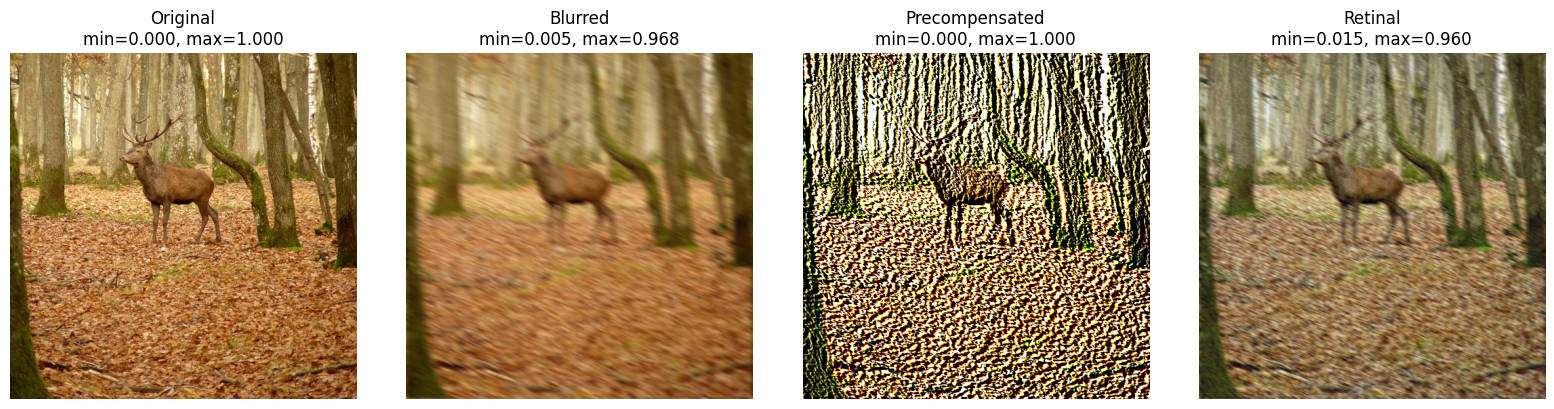

In [20]:
# Первый батч
for psfs, imgs in train_dataloader:
    psfs = psfs.to(device)
    imgs = imgs.to(device)
    blurs = fft_conv(imgs, psfs)

    with torch.inference_mode():
        model_inputs = model.preprocess(imgs, torch.fft.fftshift(psfs))
        model_inputs = tuple(
            inp.to(device) if isinstance(inp, torch.Tensor) else inp
            for inp in model_inputs
        )
        model_outputs = model(model_inputs)
        precompensated = model_outputs[0]
        retinal = fft_conv(precompensated, psfs)
    
    # Визуализируем каждый пример из батча
    for i in range(len(imgs)):
        plot_images(
            images=[imgs[i], blurs[i], precompensated[i], retinal[i]],
            titles=["Original", "Blurred", "Precompensated", "Retinal"],
            rows=1,
            figsize=(16, 4)
        )
    
    break  # только первый батч

### 📉 Функция потерь (`loss_func`)

Определена функция `loss_func`, реализующая вычисление многомасштабной структурной потери (MS-SSIM) между двумя изображениями:


In [21]:
def loss_func(img1, img2):
    device = img1.device
    ms_ssim = MultiScaleSSIMLoss().to(device)
    ms_ssim.scale_weights = ms_ssim.scale_weights.to(img1.device)
    loss = ms_ssim(img1, img2)
    return loss

### 📈 Оптимизатор и начальная скорость обучения

Для оптимизации параметров модели используется оптимизатор `Adam`:

In [22]:
initial_lr = 1e-5
optimizer_model = torch.optim.Adam(model.parameters(), lr=initial_lr)

### 🏋️‍♂️ Подготовка к обучению модели

Перед запуском цикла обучения производится инициализация необходимых инструментов и библиотек:

- Импортируются вспомогательные модули:
  - `os` — для работы с файловой системой (сохранение логов, моделей и т.д.);
  - `json` — для сохранения истории обучения или конфигураций в читаемом формате.

- Импортируются компоненты для **автоматического смешанного обучения (AMP)** из `torch.cuda.amp`:
  - `GradScaler` — масштабирует градиенты, предотвращая проблему underflow при обучении в `float16`;
  - `autocast` — автоматически переключает вычисления между `float32` и `float16` там, где это безопасно.

- Инициализируется `scaler` для управления масштабированием градиентов

In [23]:
import os
import json
from torch.cuda.amp import GradScaler, autocast
scaler = GradScaler()

/tmp/ipykernel_553/3819975532.py:4: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


In [24]:
def ensure_dir(path):
    os.makedirs(path, exist_ok=True)

def save_checkpoint(model, epoch, batch_idx, out_dir="checkpoints"):
    folder = os.path.join(out_dir, f"epoch_{epoch:03}_batch_{batch_idx:05}")
    ensure_dir(folder)
    checkpoint_path = os.path.join(folder, "model.pth")
    torch.save(model.state_dict(), checkpoint_path)
    print(f"Checkpoint saved to {checkpoint_path}")


def load_last_checkpoint(model, optimizer=None, out_dir="checkpoints"):  # returns (start_epoch, last_batch)
    if not os.path.exists(out_dir):
        return 1, 0
    # find folders epoch_{e}_batch_{b}
    folders = [d for d in os.listdir(out_dir) if d.startswith("epoch_")]
    if not folders:
        return 1, 0
    # parse and sort
    ckpts = []
    for f in folders:
        parts = f.split("_")
        try:
            e = int(parts[1])
            b = int(parts[3])
            ckpts.append((e, b, f))
        except:
            continue
    if not ckpts:
        return 1, 0
    e, b, folder = max(ckpts, key=lambda x: (x[0], x[1]))
    path = os.path.join(out_dir, folder, "model.pth")
    model.load_state_dict(torch.load(path))
    if optimizer:
        # optimizer state not saved; user may need custom
        pass
    return e, b

def train(
    model,
    train_loader: DataLoader,
    val_loader: DataLoader,
    criterion,
    optimizer,
    epochs: int,
    checkpoint_interval: int = 2000,
    device: str = 'cuda',
    plot_every: int = None,
    fast_stop:bool = False
):
    ensure_dir("checkpoints")
    ensure_dir("logs")
    model.to(device)
    # load logs if resuming
    start_epoch = 1
    metrics = {"epoch": [], "train_loss": [], "val_loss": []}
    best_train_loss = float('inf')
    best_val_loss = float('inf')
    # resume from metrics.json
    if os.path.exists("logs/metrics.json"):
        with open("logs/metrics.json", 'r') as f:
            data = json.load(f)
        metrics = data.get("metrics", metrics)
        best = data.get("best", {})
        best_train_loss = best.get("train_loss", best_train_loss)
        best_val_loss = best.get("val_loss", best_val_loss)
        if metrics["epoch"]:
            last_epoch = metrics["epoch"][-1]
            start_epoch = last_epoch + 1
            # load last checkpoint
            load_last_checkpoint(model, optimizer)
    # training loop
    for epoch in tqdm(range(start_epoch, epochs + 1), desc="Epochs"):
        model.train()
        train_losses = []
        for batch_idx, (psfs, imgs) in enumerate(tqdm(train_loader, desc="Batches", leave=False), 1):
            psfs, imgs = psfs.to(device), imgs.to(device)
            blurs = fft_conv(imgs, psfs)
            inputs = model.preprocess(imgs, torch.fft.fftshift(psfs))
            inputs = tuple(x.to(device) if isinstance(x, torch.Tensor) else x for x in inputs)
            with autocast():
                outputs = model(inputs)
            
            precompensated = outputs[0].to(torch.float32)
            retinal = fft_conv(precompensated, psfs)
            retinal = torch.nan_to_num(retinal, nan=0.0, posinf=1.0, neginf=0.0)
            retinal = torch.clip(retinal, 0, 1)
            optimizer.zero_grad()
            loss = criterion(retinal, imgs)
            
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            train_losses.append(loss.item())
            if batch_idx % checkpoint_interval == 0:
                save_checkpoint(model, epoch, batch_idx)
            if plot_every and batch_idx % plot_every == 0:
                print(f"Epoch {epoch}, Batch {batch_idx} loss: {loss.item():.4f}")
                for i in range(len(imgs)):
                    plot_images(
                        images=[imgs[i], blurs[i], precompensated[i], retinal[i]],
                        titles=["Original","Blurred","Precompensated","Retinal"],
                        rows=1, figsize=(16,4)
                    )
            if fast_stop:
                raise SystemExit(0)
                    
        mean_train_loss = sum(train_losses)/len(train_losses)
        model.eval()
        val_losses = []
        with torch.no_grad():
            for psfs, imgs in val_loader:
                psfs, imgs = psfs.to(device), imgs.to(device)
                blurs = fft_conv(imgs, psfs)
                inputs = model.preprocess(imgs, torch.fft.fftshift(psfs))
                inputs = tuple(x.to(device) if isinstance(x, torch.Tensor) else x for x in inputs)
                with autocast():
                    outputs = model(inputs)
                precompensated = outputs[0].to(torch.float32)
                retinal = fft_conv(precompensated, psfs)
                retinal = torch.nan_to_num(retinal, nan=0.0, posinf=1.0, neginf=0.0)
                retinal = torch.clip(retinal, 0, 1)
                val_losses.append(criterion(retinal, imgs).item())
        mean_val_loss = sum(val_losses)/len(val_losses)
        best_train_loss = min(best_train_loss, mean_train_loss)
        best_val_loss = min(best_val_loss, mean_val_loss)
        metrics["epoch"].append(epoch)
        metrics["train_loss"].append(mean_train_loss)
        metrics["val_loss"].append(mean_val_loss)
        ensure_dir("logs")
        with open("logs/metrics.json", 'w') as f:
            json.dump({"metrics":metrics, "best":{"train_loss":best_train_loss, "val_loss":best_val_loss}}, f, indent=4)
        print(f"Epoch {epoch}: train_loss={mean_train_loss:.4f} (best {best_train_loss:.4f}),"
              f" val_loss={mean_val_loss:.4f} (best {best_val_loss:.4f})")
    return metrics, {"best_train_loss":best_train_loss, "best_val_loss":best_val_loss}


Epochs:   0%|          | 0/1500 [00:00<?, ?it/s]/tmp/ipykernel_553/2374223800.py:81: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1, Batch 1 loss: 0.2470


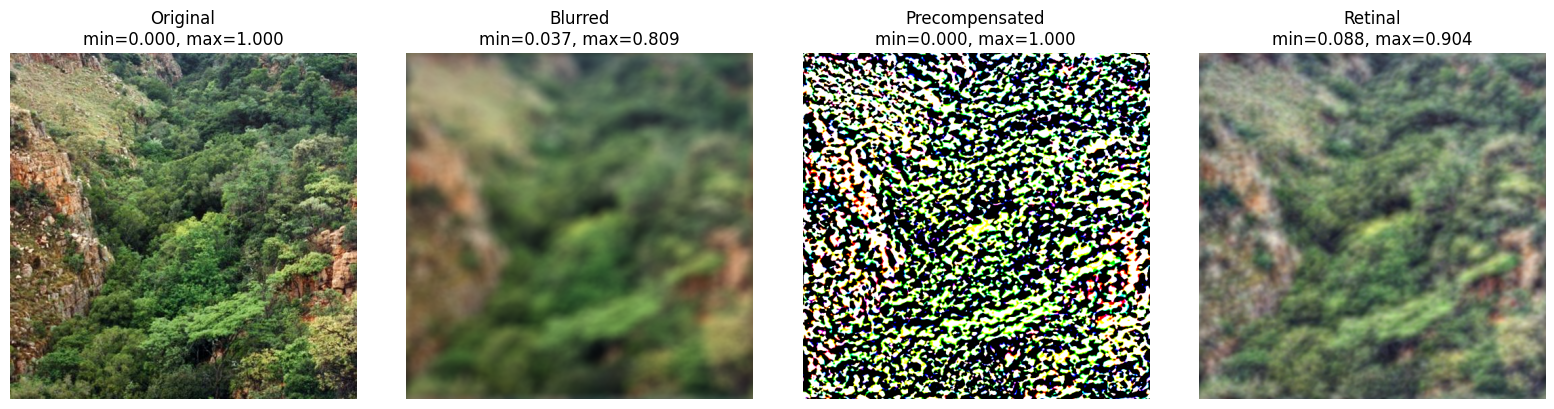

Epochs:   0%|          | 0/1500 [00:17<?, ?it/s]


SystemExit: 0

/home/devel9393/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3587: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [25]:
# Пример использования:
train(
    model=model,
    train_loader=train_dataloader,
    val_loader=val_dataloader,
    criterion=loss_func,
    optimizer=optimizer_model,
    epochs=1500,
    checkpoint_interval=2500,
    plot_every=1,
    fast_stop=True
)